# RNN Model update

In [73]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

import matplotlib.pyplot as plt
import seaborn as sns

import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Normalization, Bidirectional
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping



from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
dataset = '/Users/kieran/Desktop/Le Wag/train1_update.csv'
df = pd.read_csv(dataset)
display(df)

,id,cycle,setting1,setting2,T24_Total_temperature_at_LPC_outlet,T30_Total_temperature_at_HPC_outlet,T50_Total_temperature_at_LPT_outlet,P30_Total_pressure_at_HPC_outlet,Nf_Physical_fan_speed,Nc_Physical_core_speed,Ps30_Static_pressure_at_HPC_outlet,phi_Ratio_of_fuel_flow_to_Ps30,NRf_Corrected_fan_speed,NRc_Corrected_core_speed,BPR_Bypass_Ratio,htBleed_Bleed_Enthalpy,W31_HPT_coolant_bleed,W32_LPT_coolant_bleed,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


In [3]:
features = df.drop(['id', 'cycle', 'RUL'], axis=1)
target = df['RUL']

In [4]:
scaler = MinMaxScaler()
features_norm = scaler.fit_transform(features)


In [13]:
def create_sequences(df, features, target, cycle_length, sequence_count):
    sequences = []
    rul_values = []
    
    for engine_id in df['id'].unique():
        engine_data = features[df['id'] == engine_id]
        engine_rul = target[df['id'] == engine_id]
        
        for i in range(0, len(engine_data) - cycle_length * sequence_count + 1, cycle_length):
            seq = []
            for j in range(sequence_count):
                seq.append(engine_data[i + j * cycle_length : i + (j + 1) * cycle_length])
            sequences.append(np.concatenate(seq))
            rul_values.append(engine_rul.iloc[i + cycle_length * sequence_count - 1])
    
    return np.array(sequences), np.array(rul_values)

In [18]:
cycle_length = 30
sequence_count = 1
sequences, rul_values = create_sequences(df, features_norm, target, cycle_length, sequence_count)

In [19]:
split_ratio = 0.8
split_index = int(len(sequences) * split_ratio)

X_train, X_test = sequences[:split_index], sequences[split_index:]
y_train, y_test = rul_values[:split_index], rul_values[split_index:]


In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((514, 30, 16), (129, 30, 16), (514,), (129,))

In [21]:
normalizer = Normalization()
normalizer.adapt(X_train)

In [79]:


def build_rnn_model(input_shape):

    model = Sequential()
    model.add(normalizer)
    model.add(SimpleRNN(units=100, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(SimpleRNN(units=50, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='linear'))



     # model = Sequential()
    # model.add(Input(shape=input_shape))
    # model.add(LSTM(units=50, return_sequences=True))
    # model.add(Dropout(0.2))
    # model.add(LSTM(units=50))
    # model.add(Dropout(0.2))
    # model.add(Dense(1))
    
    
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])
    return model


    # model.compile(loss='mse', 
    #           optimizer='rmsprop',
    #          metrics=['mae', 'accuracy'])

    # model.compile(optimizer='adam', loss=tf.keras.losses.Huber())
    # return model


input_shape = (cycle_length * sequence_count, features.shape[1])
model = build_rnn_model(input_shape)

model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 30, 16)         │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_19 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_20 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33 (136.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 33 (136.00 B)

In [80]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [81]:
history = model.fit(X_train, y_train, validation_split=0.2, batch_size=16, epochs=500, callbacks=[early_stopping], verbose=1)

Epoch 1/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 14092.3828 - mae: 101.7358 - val_loss: 14978.8740 - val_mae: 102.0921
Epoch 2/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12838.3018 - mae: 94.6748 - val_loss: 14890.7334 - val_mae: 101.8433
Epoch 3/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12637.6357 - mae: 97.0973 - val_loss: 14749.7939 - val_mae: 101.3488
Epoch 4/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12177.1025 - mae: 92.8580 - val_loss: 14529.8799 - val_mae: 100.5216
Epoch 5/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12513.5107 - mae: 95.6133 - val_loss: 14283.2754 - val_mae: 99.5015
Epoch 6/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 13164.1963 - mae: 97.3379 - val_loss: 14033.8105 - val_mae: 98.3005
Epoch 7/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10880.5010 - mae: 88.5409 - val_loss: 13845.3418 - val_mae: 97.5189
Epoch 8/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12508.3838 - mae: 95.5544 - val_loss: 13689.35

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2847.1650 - mae: 40.0791 
Test Loss: [2776.804931640625, 39.2621955871582]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Mean Absolute Error (MAE): 39.26219449486843
Mean Squared Error (MSE): 2776.8049899669995
Root Mean Squared Error (RMSE): 52.69539818586628


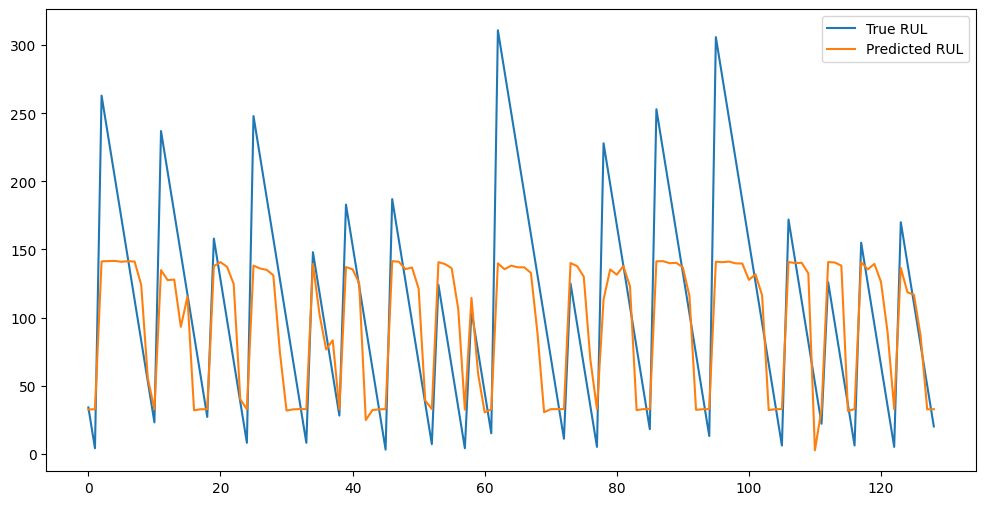

In [82]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Compute additional metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Compare predictions to the actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True RUL')
plt.plot(predictions, label='Predicted RUL')
plt.legend()
plt.show()